## Workflow

- Preprocessing
    - image resizing and normalisation

- feature extraction
    - using resnet to extract 2048 dimensional features

- dimensionality reduction
    - using pca, tsne, umap for 2d projection of latent space

- clustering
    - k means clustering 
    - evaluate quality of clusters

- classification
    - compare multiple classifiers using measurable metrics

hyperparameter tuning
    - using randomizedsearchcv for model optimisation

In [12]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
from PIL import ImageFile

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)
import joblib
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import warnings

warnings.filterwarnings('ignore')


ImageFile.LOAD_TRUNCATED_IMAGES = True


First we will set the random seed so that our results are reproducible.

In [3]:
random.seed(67)
np.random.seed(67)
torch.manual_seed(67)

Then we will define the transformation pipeline that resnet expects.

In [4]:
transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Then we will check for CUDA availability to speed up these heavy operations

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


Now we will set up feature extraction.

In [6]:
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(resnet.children())[:-1])  # remove the classification layer as we will be implementing this
model.eval()
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


We will now define our extract features function

In [7]:
def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        feats = model(batch_images)                 # [batch, 2048, 1, 1]
        feats = feats.reshape(feats.size(0), -1)    # [batch, 2048]
        return feats.cpu().numpy()

Now we will check if the image folder exists, then load it if it does.

In [9]:
if not os.path.exists("data/roads"):
    raise FileNotFoundError("roads image folder not found")

dataset_info = datasets.ImageFolder("data/roads", transform=transform)
counts = {}

for _ , label in dataset_info.samples:
    counts[label] = counts.get(label, 0) + 1

name_counts = {dataset_info.classes[i]: counts.get(i, 0) for i in range(len(dataset_info.classes))}



In [10]:
FORCE_EXTRACT = False       # change to true if you have made changes to the feature extraction

dataset = datasets.ImageFolder("data/roads", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

if (not FORCE_EXTRACT) and os.path.exists("data/features/roads_features.npy") and os.path.exists("data/features/roads_labels.npy"):
    train_features = np.load("data/features/roads_features.npy")
    train_labels = np.load("data/features/roads_labels.npy")
    print("Loaded features from file.")

else:
    train_features = []
    train_labels = []

    for imgs, labels in tqdm(loader, desc="Extracting features"):
        batch_feats = extract_features(imgs)
        train_features.append(batch_feats)
        train_labels.append(labels.numpy())

    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    print("Feature vectors shape:", train_features.shape)
    print("Labels shape:", train_labels.shape)

    os.makedirs("data/features", exist_ok=True)
    np.save("data/features/roads_features.npy", train_features)
    np.save("data/features/roads_labels.npy", train_labels)

Extracting features: 100%|██████████| 146/146 [00:04<00:00, 33.37it/s]

Feature vectors shape: (4656, 2048)
Labels shape: (4656,)


Now we are going to analyse the distribution of our data.

In [15]:
print("\nClass Distribution:")
print("-" * 50)
for i, class_name in enumerate(dataset.classes):
    count = np.sum(train_labels == i)
    percentage = (count / len(train_labels)) * 100
    print(f"{class_name:20s}: {count:4d} samples ({percentage:5.1f}%)")


Class Distribution:
--------------------------------------------------
Daylight            :  903 samples ( 19.4%)
Night               : 1050 samples ( 22.6%)
RainyDay            : 1049 samples ( 22.5%)
RainyNight          :  431 samples (  9.3%)
Snowy               :  569 samples ( 12.2%)
SunStroke           :  347 samples (  7.5%)
Tunnel              :  307 samples (  6.6%)


Because this data is sequential, we must treat it a bit differnetly. We are going to use StratifiedShuffleSplit.

In [16]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=67)

for train_idx, test_idx in splitter.split(train_features, train_labels):
    X_train, X_test = train_features[train_idx], train_features[test_idx]
    y_train, y_test = train_labels[train_idx], train_labels[test_idx]
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3724 samples
Test set: 932 samples


## Dimensionality Reduction of the latent space

We are using PCA and T-sne and comparing the outputs from these.

PCA explained variance ratio: [0.25085852 0.16476282]
Total variance explained: 0.4156


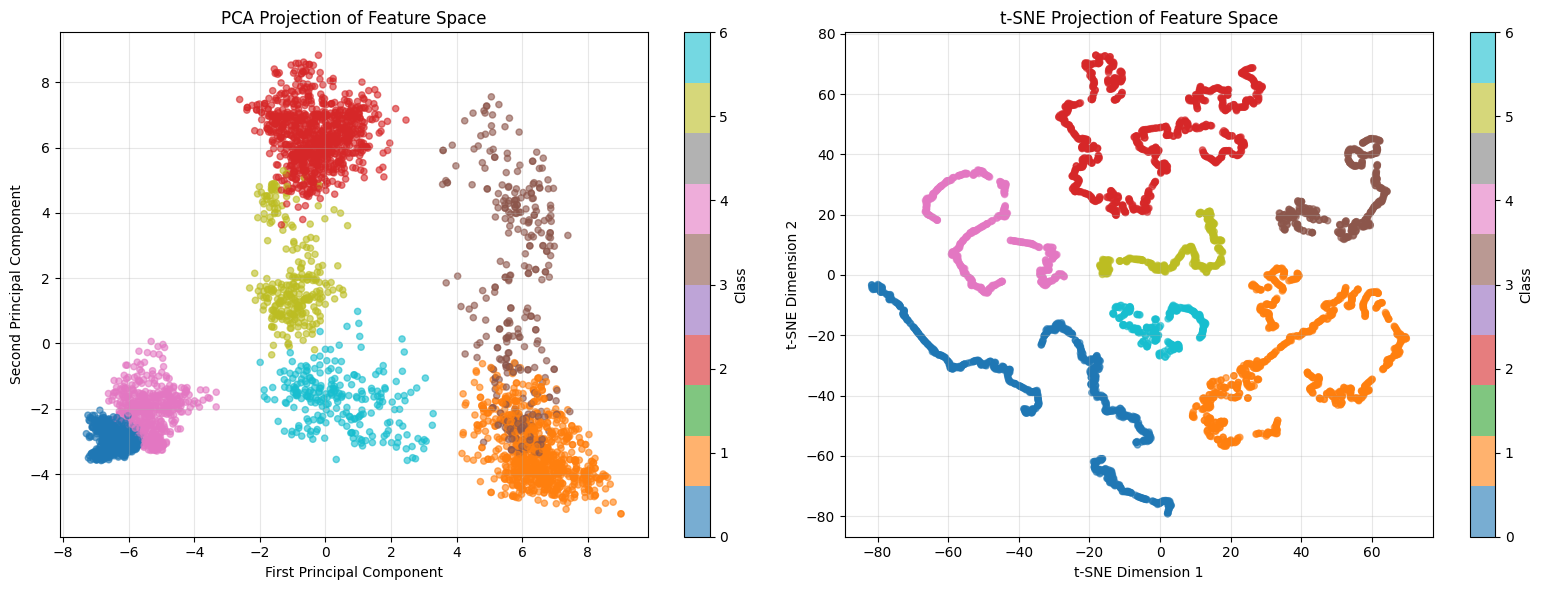


Class labels: ['Daylight', 'Night', 'RainyDay', 'RainyNight', 'Snowy', 'SunStroke', 'Tunnel']


In [18]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=67)
X_pca = pca.fit_transform(X_train)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Apply t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, random_state=67, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_train)

# Visualize both projections
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=0.6, s=20)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('PCA Projection of Feature Space')
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Class')

# t-SNE visualization
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('t-SNE Projection of Feature Space')
axes[1].grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Class')

plt.tight_layout()
plt.show()

print(f"\nClass labels: {dataset.classes}")

We are then going to define our classifiers, and run them.
We will be using cross-validation training in order to estimate generalisation performance.

In [21]:
classifiers = {
    'Logistic Regression': make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, solver="lbfgs", random_state=67, n_jobs=-1)
    ),
    'KNN (k=5)': make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    ),
    'SVM (Linear)': make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', probability=True, random_state=67)
    ),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=67),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=20, random_state=67, n_jobs=-1
    )
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
results = {}

for clf_name, clf in tqdm(classifiers.items(), desc="Training classifiers"):
    fold_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        clf.fit(X_fold_train, y_fold_train)
        y_pred = clf.predict(X_fold_val)
        fold_scores.append(accuracy_score(y_fold_val, y_pred))
    
    # Train on full training set and evaluate on test set
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    results[clf_name] = {
        'model': clf,
        'cv_accuracy': np.mean(fold_scores),
        'cv_std': np.std(fold_scores),
        'fold_scores': fold_scores,
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'predictions': y_test_pred
    }

print("\nCross-Validation Results:")

print("-" * 60)

for clf_name, result in sorted(results.items(), key=lambda x: x[1]['cv_accuracy'], reverse=True):
    print(f"{clf_name:20s}: {result['cv_accuracy']:.4f} ± {result['cv_std']:.4f}")

Training classifiers: 100%|██████████| 5/5 [00:44<00:00,  8.96s/it]


Cross-Validation Results:
------------------------------------------------------------
Logistic Regression : 1.0000 ± 0.0000
SVM (Linear)        : 1.0000 ± 0.0000
Random Forest       : 1.0000 ± 0.0000
KNN (k=5)           : 0.9995 ± 0.0007
Decision Tree       : 0.9914 ± 0.0040


Now to compare all of our metrics between classifiers

In [22]:
print("\nPerformance Metrics:")
print("=" * 100)
print(f"{'Classifier':<25} {'CV Acc':<12} {'Test Acc':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 100)

for clf_name in sorted(results.keys(), key=lambda x: results[x]['test_accuracy'], reverse=True):
    result = results[clf_name]
    y_pred = result['predictions']
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    
    print(f"{clf_name:<25} {result['cv_accuracy']:<12.4f} {result['test_accuracy']:<12.4f} "
          f"{precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

print("=" * 100)
print("\nNote: All metrics are macro-averaged across all classes")


Performance Metrics:
Classifier                CV Acc       Test Acc     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
Logistic Regression       1.0000       1.0000       1.0000       1.0000       1.0000      
SVM (Linear)              1.0000       1.0000       1.0000       1.0000       1.0000      
Random Forest             1.0000       1.0000       1.0000       1.0000       1.0000      
KNN (k=5)                 0.9995       0.9989       0.9993       0.9977       0.9985      
Decision Tree             0.9914       0.9946       0.9943       0.9945       0.9944      

Note: All metrics are macro-averaged across all classes


Now to use learning curves to check for  overfitting

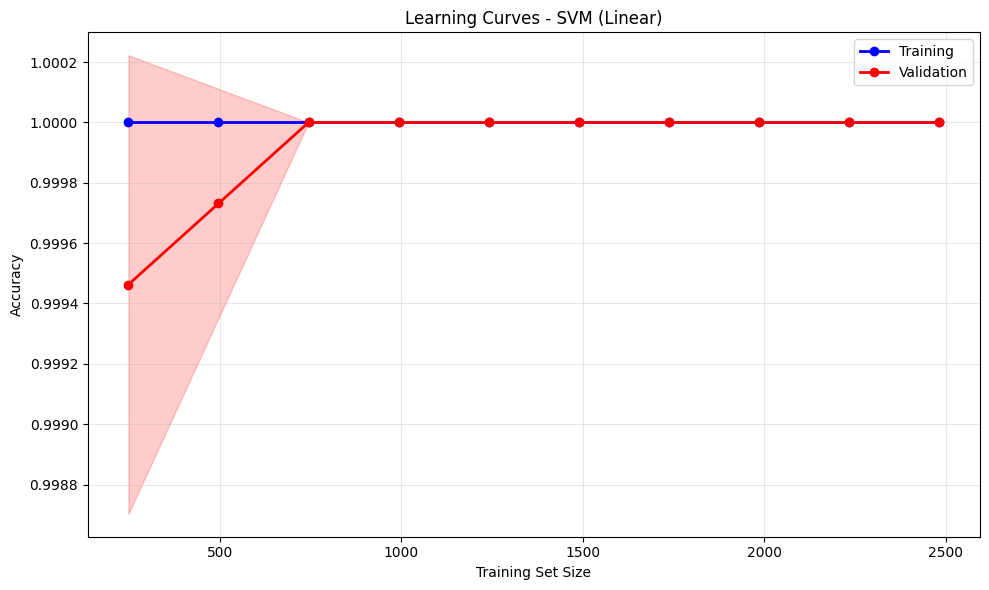


Learning Curve Analysis (SVM):
Training Score: 1.0000 | Validation Score: 1.0000
Train-Val Gap: 0.0000
✓ Good!


In [23]:
# Learning curves for SVM
train_sizes, train_scores, val_scores = learning_curve(
    results['SVM (Linear)']['model'], X_train, y_train,
    cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
val_mean, val_std = np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves - SVM (Linear)')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

gap = train_mean[-1] - val_mean[-1]
print(f"\nLearning Curve Analysis (SVM):")
print(f"Training Score: {train_mean[-1]:.4f} | Validation Score: {val_mean[-1]:.4f}")
print(f"Train-Val Gap: {gap:.4f}")
